In [1]:
!nvidia-smi

Thu Oct 28 09:34:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tfa-nightly
!pip install import-ipynb
import import_ipynb
import tensorflow as tf
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from __future__ import division, print_function
import keras.losses
from tqdm import tqdm
from fastprogress import master_bar, progress_bar
%cd /content/drive/MyDrive/MRI_ACDCA/
import lovasz_losses_tf as L

/content/drive/.shortcut-targets-by-id/1kdKWMtQq063wklZtXKlzGd-nUeOnEiDw/MRI_ACDCA


In [4]:
%run /content/drive/MyDrive/MRI_ACDCA/UnetModel.ipynb #UnetModel.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1kdKWMtQq063wklZtXKlzGd-nUeOnEiDw/MRI_ACDCA
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
______________________________________________________________________________

In [5]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-10):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=1e-10):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def sen(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    sen = true_pos/(true_pos + false_neg)
    spe = true_neg/(true_neg + false_pos)
    return sen

def spe(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    sen = true_pos/(true_pos + false_neg)
    spe = true_neg/(true_neg + false_pos)
    return spe

def accuracy(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    p = (true_pos + true_neg + smooth)/(true_pos + true_neg + false_pos + false_neg + smooth)
    return p

In [6]:
x = np.asarray(np.load('/content/drive/MyDrive/MRI_ACDCA/Dataset/x_crop_128.npy'),np.float32)
y = np.load('/content/drive/MyDrive/MRI_ACDCA/Dataset/y_crop_128.npy')

#x = np.asarray(np.load('./paperLMSloss/dataACDCA/x_crop_128.npy'),np.float32)
#y = np.load('./paperLMSloss/dataACDCA/y_crop_128.npy')

In [7]:
np.random.seed(123)
len_dev = x.shape[0]//5
len_train = x.shape[0] - len_dev
rand_index = np.random.permutation(x.shape[0])
x_test = x[rand_index[:len_dev]]
y_test = y[rand_index[:len_dev]]
x_train = x[rand_index[len_dev:]]
y_train = y[rand_index[len_dev:]]

In [8]:
# plt.figure(1)
# label_endo = tf.where(y_test == 2.0, 1.0, 0.0)
# label_epi =  tf.where(y_test == 1.0, 1.0, 0.0) + label_endo
# plt.subplot(131),plt.imshow(x[102][...,0],cmap='gray')
# plt.subplot(132),plt.imshow(label_epi[102][...,0],cmap='gray')
# plt.subplot(133),plt.imshow(y_test[102][...,0],cmap='gray')

In [9]:
BATCH_SIZE = 16
buffer_size = x_train.shape[0]

def flip(image,mask):
  
  if tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  if tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
  return image, mask
def brightness(image, mask):

  """
  Randomly applies a random brightness change.
  """
  cond_brightness = tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool)
  image = tf.cond(cond_brightness, lambda: tf.image.random_brightness(
      image, 0.2), lambda: tf.identity(image))
  return image, mask


def contrast(image, mask):

  """
  Randomly applies a random contrast change.
  """
  cond_contrast = tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool)
  image = tf.cond(cond_contrast, lambda: tf.image.random_contrast(
      image, 0.1, 0.8), lambda: tf.identity(image))
  return image, mask


def saturation(image, mask):

  """
  Randomly applies a random saturation change.
  """
  cond_saturation = tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool)
  image = tf.cond(cond_saturation, lambda: tf.image.random_saturation(
      image, 0.1, 0.5), lambda: tf.identity(image))
  return image, mask

def rotate_image(image, mask,angle=30):

  if tf.cast(tf.random.uniform([], maxval=2, dtype=tf.int32), tf.bool):
    comb = tf.concat([image,mask],axis=-1)
    comb = tfa.image.rotate(comb, angles=np.random.uniform(-angle, angle)*np.math.pi / 180)
    image,mask =  tf.split(comb, [image.shape[-1], mask.shape[-1]], axis=-1)
  return image, mask
def normalize(image,mask):
  image = tf.cast(image, tf.float32) / 255.0
  return image,mask
@tf.function
def gen_image(image,mask):
  # image, mask = brightness(image,mask)
  #image, mask = saturation(image,mask)
  image, mask = flip(image,mask)
  image, mask = rotate_image(image,mask)
  image, mask = normalize(image, mask)
  return image, mask
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(buffer_size).map(gen_image).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).map(normalize).batch(BATCH_SIZE*2)

In [10]:
class MSLoss_vs2():
  def levelsetLoss(self,target, output, kernel_size = 7):
    loss = 0.0
    yn = output
    # yn = output[...,:-1]
    # bn = output[...,-1:]
    kernel = tf.ones([kernel_size, kernel_size, 1, yn.shape[-1]],tf.float32) / (kernel_size**2)
    for ich in range(target.shape[-1]):
        target_ = target[...,ich:ich+1]    
        pcentroid_1 = tf.nn.conv2d( target_ * yn, kernel, strides=1, padding='SAME')
        pcentroid_2 =  tf.nn.conv2d(yn+1e-6, kernel, strides=1, padding='SAME')
        # pcentroid = tf.reduce_sum(pcentroid_1, (1,2),keepdims=True)/tf.reduce_sum(pcentroid_2 (1,2),keepdims = True)   
        pcentroid = pcentroid_1 / pcentroid_2
        plevel = target_ - pcentroid
        pLoss = plevel * plevel * yn
        loss += tf.reduce_sum(pLoss)
    return loss
      
  def activeContourLoss(self,y_true,y_pred,outDim =3,smooth=0.001):     
    yTrueOnehot = tf.one_hot(tf.squeeze(tf.cast(y_true,tf.uint8),axis=-1), depth = outDim)
    loss =  y_pred * (1-yTrueOnehot) + (1-y_pred)*yTrueOnehot
    return tf.reduce_mean(loss)
    #this is Luac:
    # loss =  - tf.cast(tf.math.log(1-y_pred+smooth),tf.float32) * (1-yTrueOnehot ) - tf.cast(tf.math.log(y_pred+smooth),tf.float32)*yTrueOnehot
    # return tf.reduce_mean(loss)
                    
  def gradientLoss(self,input,penalty = "l1"):

    dH = tf.math.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = tf.math.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    if penalty == "l2":
        dH = dH * dH
        dW = dW * dW

    loss =  tf.reduce_sum(dH) +  tf.reduce_sum(dW)
    return loss

  def tversky_kahneman(self, target, output, alpha=0.5, beta=0.5, gamma=4/3, smooth=1e-10):
    #output = tf.expand_dims(tf.argmax(output, axis=-1), axis = -1)
    #output = tf.cast(output, tf.float32)
    target = tf.one_hot(tf.squeeze(tf.cast(target, tf.uint8), axis=-1), depth=2)
    target = tf.cast(target, tf.float32)

    target_positive = K.flatten(target) 
    output_positive = K.flatten(output) 

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    p = 0.5*(true_pos + true_neg)/(0.5*true_pos + 0.5*true_neg + alpha*false_pos + beta*false_neg)  
    p_gamma = K.pow(p,gamma) #p^gamma
    _p_gamma = K.pow(1-p, gamma) #(1-p)^gamma
    loss = _p_gamma/K.pow(p_gamma + _p_gamma, 1/gamma)

    return loss

In [11]:
class Mumford_Unet_vs2(MSLoss_vs2):
  def __init__(self,model):
    super().__init__()
    self.model = model
    self.optimizer = None
    self.trainData = None
    self.testData = None
    self.batch_size = BATCH_SIZE
    temp = x_train.shape[0] // self.batch_size
    self.train_step = temp + 1 if x_train.shape[0] % self.batch_size != 0 else temp
    self.learning_rate = 0.001

  def optimizer_fc(self,op_type = "adam", op_param = 0.005):
    if op_type == 'adam':
      self.optimizer =  tf.keras.optimizers.Adam(op_param)
    elif op_type == "nadam":
      self.optimizer =  tf.keras.optimizers.Nadam(op_param)

  def loss(self, image, output, trueLabel, alpha = 1e-7, beta = 1e-2):
    # print('\ractive loss: ',self.activeContourLoss(trueLabel, output),' leverset loss: ', self.levelsetLoss(image,output),'gradient loss: ', self.gradientLoss(output), end="")
    loss = alpha * ( self.levelsetLoss(image,output) + beta * self.gradientLoss(output)) + self.activeContourLoss(trueLabel, output) 
            #+ self.tversky_kahneman(trueLabel, output, alpha=0.5, beta=0.5, gamma=4/3, smooth=1e-10)
    # return self.activeContourLoss(trueLabel, output)
    #self.lovasz(output, trueLabel, ignore=IGNORE, per_image=False) 
    #loss = self.tversky_kahneman(trueLabel, output, alpha=0.5, beta=0.5, gamma=4/3, smooth=1e-10)
    return loss

  def metrics(self,y_true,y_pred):
    output_standard = tf.expand_dims(tf.argmax(y_pred,axis=-1),axis = -1)
    output_endo = tf.where(output_standard == 2, 1.0, 0.0)
    output_epi =  tf.where(output_standard == 1, 1.0, 0.0) + output_endo
    label_endo = tf.where(y_true == 2, 1.0, 0.0)
    label_epi =  tf.where(y_true == 1, 1.0, 0.0) + label_endo

    dice_coef_endo = dice_coef(label_endo, output_endo)
    dice_coef_epi = dice_coef(label_epi, output_epi)

    jaccards_coef_endo = jaccard_coef(label_endo, output_endo)
    jaccards_coef_epi = jaccard_coef(label_epi, output_epi)

    sen_endo = sen(label_endo, output_endo)
    sen_epi = sen(label_epi, output_epi)

    spe_endo = spe(label_endo, output_endo)
    spe_epi = spe(label_epi, output_epi)

    acc_endo = accuracy(label_endo, output_endo)
    acc_epi = accuracy(label_epi, output_epi)
    return dice_coef_endo, dice_coef_epi, jaccards_coef_endo, jaccards_coef_epi, sen_endo, sen_epi, spe_endo, spe_epi, acc_endo, acc_epi

  def evaluateTest(self,testDataset):
    test_dices_endo =  []
    test_dices_epi = []
    test_jaccards_endo =  []
    test_jaccards_epi = []
    test_sen_endo = []
    test_sen_epi = []
    test_spe_endo = []
    test_spe_epi = []
    test_acc_endo = []
    test_acc_epi = []

    for xBatchTest, yBatchTest in testDataset:
      yPredBatchTest = self.model(xBatchTest, training = False)
      diceEndoTest, diceEpiTest, jaccardEndoTest, jaccardEpiTest, senEndoTest, senEpiTest, speEndoTest, speEpiTest, accEndoTest, accEpiTest =  self.metrics(yBatchTest, yPredBatchTest)

      test_dices_endo.append(diceEndoTest)
      test_dices_epi.append(diceEpiTest)
      test_jaccards_endo.append(jaccardEndoTest)
      test_jaccards_epi.append(jaccardEpiTest)
      test_sen_endo.append(senEndoTest)
      test_sen_epi.append(senEpiTest)
      test_spe_endo.append(speEndoTest)
      test_spe_epi.append(speEpiTest)
      test_acc_endo.append(accEndoTest)
      test_acc_epi.append(accEpiTest)
    return np.mean(test_dices_endo), np.mean(test_dices_epi), np.mean(test_jaccards_endo), np.mean(test_jaccards_epi), np.mean(test_sen_endo), np.mean(test_sen_epi), np.mean(test_spe_endo), np.mean(test_spe_epi), np.mean(test_acc_endo), np.mean(test_acc_epi)
    
  def epoch_training(self,model,optimizer, trainDataset, testDataset, mb, stepTrain, alpha_loss, beta_loss):
    train_losses = []
    train_dices_endo =  []
    train_dices_epi = []
    train_jaccards_endo =  []
    train_jaccards_epi = []
    train_sen_endo = []
    train_sen_epi = []
    train_spe_endo = []
    train_spe_epi = []
    train_acc_endo = []
    train_acc_epi = []

    trainDataset = iter(trainDataset)  
    
    for _ in progress_bar(range(stepTrain),parent = mb):   
      image, y_true = next(trainDataset)
      with tf.GradientTape() as tape:
        y_pred = self.model(image, training = True)
        total_loss  =  self.loss(image, y_pred, y_true, alpha_loss, beta_loss)
      grad  = tape.gradient(total_loss, self.model.trainable_variables)
      optimizer.apply_gradients(zip(grad,self.model.trainable_variables))
      # y_pred, total_loss = self.step(image, y_true)
      diceEndoTrain, diceEpiTrain, jaccardEndoTrain, jaccardEpiTrain, senEndoTrain, senEpiTrain, speEndoTrain, speEpiTrain, accEndoTrain, accEpiTrain =  self.metrics(y_true, y_pred)

      mb.child.comment = 'Train loss {:.4f}'.format(total_loss)

      train_losses.append(total_loss)
      train_dices_endo.append(diceEndoTrain)
      train_dices_epi.append(diceEpiTrain)
      train_jaccards_endo.append(jaccardEndoTrain)
      train_jaccards_epi.append(jaccardEpiTrain)
      train_sen_endo.append(senEndoTrain)
      train_sen_epi.append(senEpiTrain)
      train_spe_endo.append(speEndoTrain)
      train_spe_epi.append(speEpiTrain)
      train_acc_endo.append(accEndoTrain)
      train_acc_epi.append(accEpiTrain)

    trainLossMean = np.mean(train_losses)
    trainDiceEndoMean = np.mean(train_dices_endo)
    trainJaccardEndoMean = np.mean(train_jaccards_endo)
    trainDiceEpiMean = np.mean(train_dices_epi)
    trainJaccardEpiMean = np.mean(train_jaccards_epi)
    trainSenEndoMean = np.mean(train_sen_endo) 
    trainSenEpiMean = np.mean(train_sen_epi)
    trainSpeEndoMean = np.mean(train_spe_endo)
    trainSpeEpiMean = np.mean(train_spe_epi)
    trainAccEndoMean = np.mean(train_acc_endo) 
    trainAccEpiMean = np.mean(train_acc_epi)

    testDiceEndoMean, testDiceEpiMean, testJaccardEndoMean, testJaccardEpiMean, testSenEndoMean, testSenEpiMean, testSpeEndoMean, testSpeEpiMean, testAccEndoMean, testAccEpiMean = self.evaluateTest(testDataset)

    return trainLossMean, trainDiceEndoMean, trainDiceEpiMean, trainJaccardEndoMean, trainJaccardEpiMean, trainSenEndoMean, trainSenEpiMean, trainSpeEndoMean, trainSpeEpiMean, trainAccEndoMean, trainAccEpiMean, testDiceEndoMean, testDiceEpiMean, testJaccardEndoMean, testJaccardEpiMean, testSenEndoMean, testSenEpiMean, testSpeEndoMean, testSpeEpiMean, testAccEndoMean, testAccEpiMean


  def train(self,num_epoch, reduceLrEpoch=10 , earlyStoping=200, minLr=1e-5, alpha_loss= 0.5, beta_loss = 0.5,checkpoint_prefix = "./weightAlpha(1e-6)/ckpt_{score:.4f}.h5"):
    mb = master_bar(range(num_epoch))
    epochs_list = []
    history = dict()
    training_losses = []
    trainDiceEndo_list = []
    trainDiceEpi_list = []
    trainJaccardEndo_list = []
    trainJaccardEpi_list = []
    trainSenEndo_list = []
    trainSenEpi_list = []
    trainSpeEndo_list = []
    trainSpeEpi_list = []
    trainAccEndo_list = []
    trainAccEpi_list = []

    testDiceEndo_list = []
    testDiceEpi_list = []
    testJaccardEndo_list = []
    testJaccardEpi_list = []
    testSenEndo_list = []
    testSenEpi_list = []
    testSpeEndo_list = []
    testSpeEpi_list = []
    testAccEndo_list = []
    testAccEpi_list = []

    # learningRate_list = []
    best_score  = 0.95
    count = 0
    for epoch in mb:
      count += 1
      epochs_list.append(epoch+1)

      trainLoss, trainDiceEndo, trainDiceEpi, trainJaccardEndo, trainJaccardEpi, trainSenEndo, trainSenEpi, trainSpeEndo, trainSpeEpi, trainAccEndo, trainAccEpi, testDiceEndo, testDiceEpi, testJaccardEndo, testJaccardEpi, testSenEndo, testSenEpi, testSpeEndo, testSpeEpi, testAccEndo, testAccEpi = self.epoch_training(self.model, self.optimizer, self.trainData, self.testData, mb, self.train_step, alpha_loss, beta_loss)

      mb.write('Finish train epoch {} with loss {:.4f} trainDiceEndo: {:.2f}, trainDiceEpi: {:.2f}, trainJaccardEndo: {:.2f}, trainJaccardEpi: {:.2f}, trainSenEndo: {:.2f}, trainSenEpi: {:.2f}, trainSpeEndo: {:.2f}, trainSpeEpi: {:.2f}, trainAccEndo: {:.2f}, trainAccEpi: {:.2f}, testDiceEndo: {:.4f}, testDiceEpi: {:.4f}, testJaccardEndo: {:.4f}, testJaccardEpi: {:.4f}, testSenEndo: {:.4f}, testSenEpi: {:.4f}, testSpeEndo: {:.4f}, testSpeEpi: {:.4f}, testAccEndo: {:.4f}, testAccEpi: {:.4f}'.format(epoch+1, trainLoss, trainDiceEndo, trainDiceEpi, trainJaccardEndo, trainJaccardEpi, trainSenEndo, trainSenEpi, trainSpeEndo, trainSpeEpi, trainAccEndo, trainAccEpi, testDiceEndo, testDiceEpi, testJaccardEndo, testJaccardEpi, testSenEndo, testSenEpi, testSpeEndo, testSpeEpi, testAccEndo, testAccEpi))

      training_losses.append(trainLoss)
      trainDiceEndo_list.append(trainDiceEndo)
      trainDiceEpi_list.append(trainDiceEpi)
      trainJaccardEndo_list.append(trainJaccardEndo)
      trainJaccardEpi_list.append(trainJaccardEpi)
      trainSenEndo_list.append(trainSenEndo)
      trainSenEpi_list.append(trainSenEpi)
      trainSpeEndo_list.append(trainSpeEndo)
      trainSpeEpi_list.append(trainSpeEpi)
      trainAccEndo_list.append(trainAccEndo)
      trainAccEpi_list.append(trainAccEpi)

      testDiceEndo_list.append(testDiceEndo)
      testDiceEpi_list.append(testDiceEpi)
      testJaccardEndo_list.append(testJaccardEndo)
      testJaccardEpi_list.append(testJaccardEpi)
      testSenEndo_list.append(testSenEndo)
      testSenEpi_list.append(testSenEpi)
      testSpeEndo_list.append(testSpeEndo)
      testSpeEpi_list.append(testSpeEpi)
      testAccEndo_list.append(testAccEndo)
      testAccEpi_list.append(testAccEpi)
      # learningRate_list.append(self.learning_rate)

      if count % reduceLrEpoch ==0 :
        self.learning_rate = self.learning_rate * 0.5
        if self.learning_rate < minLr:
          self.learning_rate = minLr
        print('learning rate is set to : ',self.learning_rate)
        self.optimizer.learning_rate.assign(self.learning_rate )
    
      mb.update_graph([[epochs_list, training_losses]], [0,num_epoch], [0,0.1])
      if count == earlyStoping :
        break
      ### Check point here ###
      ### Check point follow testDiceEpi ###
      if best_score < testDiceEndo:
          count = 0
          mb.write(">>> Improved Dice-score ENDO from {:.4f} to {:.4f}".format(best_score, testDiceEndo))
          best_score = testDiceEndo
          self.model.save_weights(checkpoint_prefix.format(score=best_score))
    history['epoch'] = epochs_list
    history['train_loss'] = training_losses
    history['train_dice_endo'] = trainDiceEndo_list
    history['train_dice_epi'] = trainDiceEpi_list
    history['test_dice_endo'] = testDiceEndo_list
    history['test_dice_epi'] = testDiceEpi_list
    # history['lr'] = learningRate_list
    return history 

In [12]:
#S = seg_net()
nhat = Mumford_Unet_vs2(generator)
nhat.learning_rate = 0.001
nhat.trainData = train_dataset
nhat.testData = test_dataset
nhat.optimizer_fc(op_type = "nadam", op_param=nhat.learning_rate)

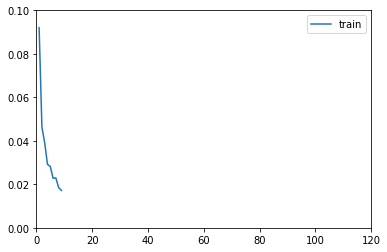

In [ ]:
history = nhat.train(120,alpha_loss=1e-7,beta_loss=1e-2,checkpoint_prefix="/content/drive/MyDrive/MRI_ACDCA/checkpoint/ckpt_{score:.4f}.h5")

In [ ]:
sio.savemat('/content/drive/MyDrive/MRI_ACDCA/checkpoint/history.mat',history)

In [ ]:
nhat.model.load_weights('/content/drive/MyDrive/MRI_ACDCA/checkpoint/ckpt_0.9202.h5')

In [ ]:
nhat.evaluateTest(test_dataset)

(0.92519265, 0.9405387, 0.88517827, 0.9115893)

In [ ]:
for i in range(x_test.shape[0]):
  y_pred = nhat.model(normalize(x_test[i:i+1],y_test[i:i+1]))
  y_predShow = np.argmax(y_pred,axis = -1)
  plt.figure(i+1)
  plt.subplot(131),plt.imshow(x_test[i,...,0],cmap='gray'),plt.title('image')
  plt.subplot(132),plt.imshow(y_predShow[0],cmap ='gray'),plt.title('predict')
  plt.subplot(133),plt.imshow(y_test[i,...,0],cmap='gray'),plt.title('groundtruth')